In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
dataset="C:\\Users\\aryan\\Group4-Codes\\normal"
imagePaths=list(paths.list_images(dataset))


data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(400,400))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)


In [5]:
len(data)

186

In [6]:
labels[0]

'normal'

In [7]:
dataset="C:\\Users\\aryan\\Group4-Codes\\osteporosis"
imagePaths=list(paths.list_images(dataset))

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(400,400))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

In [8]:
data[0]

array([[[-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        ...,
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ]],

       [[-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        ...,
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ]],

       [[-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        ...,
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ],
        [-103.939  , -116.779  , -123.68   ]],

       ...,

       [[ 151.061  ,  138.22101,  131.32   ],
        [ 151.061  ,  138.22101,  131.32   ],
        [ 151.061  ,  

In [9]:
labels[200]

'osteporosis'

In [10]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [11]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
#labels=to_categorical(labels)

In [12]:
dev_X,test_X,dev_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [13]:
train_X, valid_X, train_Y, valid_Y = train_test_split(dev_X,dev_Y,test_size=0.125, random_state=10)

In [14]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,brightness_range=[0.5,1.5],fill_mode='nearest')

In [15]:
baseModel=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(400,400,3)))

print(baseModel.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [16]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(1,activation='sigmoid')(headModel)

In [17]:
model=Model(inputs=baseModel.input,outputs=headModel)

In [18]:
for layer in baseModel.layers:
    layer.trainable=False

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [19]:
learning_rate=0.001
Epochs=50
BS=16

In [20]:
opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(valid_X,valid_Y),
    validation_steps=len(valid_X)//BS,
    epochs=Epochs
)

D:\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
16/16 [==============================] - 74s 5s/step - loss: 1.1586 - accuracy: 0.5781 - val_loss: 0.9696 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 73s 5s/step - loss: 0.9296 - accuracy: 0.6255 - val_loss: 0.5774 - val_accuracy: 0.7632
Epoch 3/50
16/16 [==============================] - 73s 5s/step - loss: 0.9758 - accuracy: 0.6132 - val_loss: 0.5592 - val_accuracy: 0.7632
Epoch 4/50
16/16 [==============================] - 73s 5s/step - loss: 0.7034 - accuracy: 0.6914 - val_loss: 0.5592 - val_accuracy: 0.7105
Epoch 5/50
16/16 [==============================] - 73s 5s/step - loss: 0.7044 - accuracy: 0.6584 - val_loss: 0.5305 - val_accuracy: 0.7632
Epoch 6/50
16/16 [==============================] - 73s 5s/step - loss: 0.6838 - accuracy: 0.6790 - val_loss: 0.6090 - val_accuracy: 0.6842
Epoch 7/50
16/16 [==============================] - 76s 5s/step - loss: 0.6517 - accuracy: 0.6680 - val_loss: 0.5186 - val_accuracy: 0.7368
Epoch 8/50
16/16 [==

In [21]:
predict=model.predict(test_X,batch_size=BS)
predict=np.round_(predict)
print(classification_report(test_Y,predict,target_names=lb.classes_))

5/5 [==============================] - 19s 4s/step
              precision    recall  f1-score   support

      normal       0.83      0.54      0.66        37
 osteporosis       0.67      0.89      0.76        38

    accuracy                           0.72        75
   macro avg       0.75      0.72      0.71        75
weighted avg       0.75      0.72      0.71        75



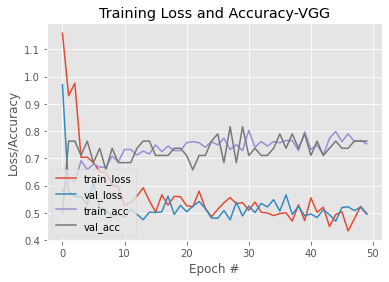

In [31]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy-VGG")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

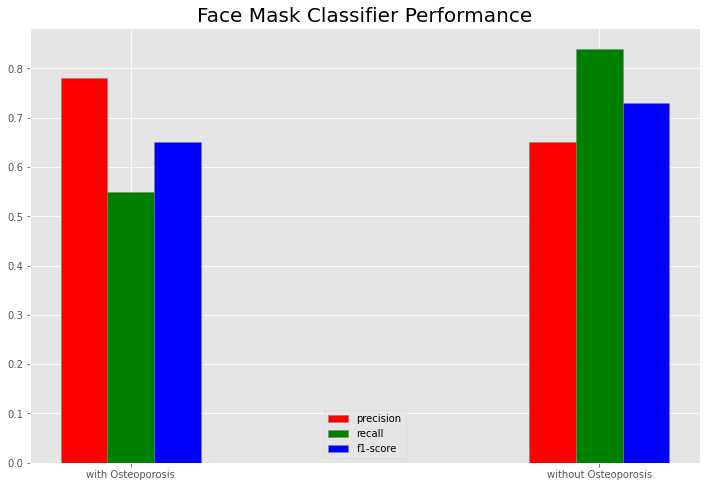

In [23]:
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))

precision = [0.78, 0.65]
recall = [0.55, 0.84]
f1 = [0.65, 0.73]

br1 = np.arange(len(precision))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, precision, color ='r', width = barWidth, edgecolor ='grey', label ='precision')
plt.bar(br2, recall, color ='g', width = barWidth, edgecolor ='grey', label ='recall')
plt.bar(br3, f1, color ='b', width = barWidth, edgecolor ='grey', label ='f1-score')

plt.title("Face Mask Classifier Performance", fontsize = 20)
plt.xticks([r + barWidth for r in range(len(precision))],
        ['with Osteoporosis', 'without Osteoporosis'])
 
plt.legend()
plt.show()

In [24]:
#model.save('VGG-Osteoporosis Classification')

In [25]:
#import pickle

In [26]:
#filename = 'VGG_Osteoporosis_model.sav'
#pickle.dump(model, open(filename, 'wb'))

In [27]:
save_path = './Osteoporosis_Classification_VGG_model.h5'
model.save(save_path)


In [28]:
#import tensorflow as tf
#m1 = tf.keras.models.load_model(save_path)

In [29]:
#result = m1.predict(np.array(data[0])